In [1]:
x=1

In [2]:
import multimil as mtm
import scanpy as sc
import scvi
import pandas as pd
import sklearn
import numpy as np
import torch

[rank: 0] Global seed set to 0


In [26]:
sc.set_figure_params(vector_friendly=True)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

[rank: 0] Global seed set to 0


Last run with scvi-tools version: 0.20.3


In [5]:
adata_msi = sc.read('../../vitatrack/datasets/MSI_concat_lipids.h5ad')
adata_rna = sc.read('../../vitatrack/datasets/RNA_concat_lipids.h5ad')

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
adata_rna.obs['split'] = 'train'
adata_rna.obs.loc[adata_rna.obs['slide'] == 'V11L12-038_B1', 'split'] = 'test'

In [7]:
adata_msi.obs['split'] = adata_rna.obs['split']

In [8]:
adata_msi = adata_msi[:,adata_msi.var['msi_highly_variable']].copy()
adata_rna = adata_rna[:,adata_rna.var['gex_highly_variable']].copy()

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [9]:
adata_rna.X = adata_rna.layers['counts'].copy()

In [10]:
adata_rna.obs_names_make_unique()
adata_msi.obs_names_make_unique()

In [11]:
adata_msi.write('../pipeline/data/adata_visium_maldi_msi.h5ad')
adata_rna.write('../pipeline/data/adata_visium_maldi_rna.h5ad')

In [11]:
test_idx = adata_msi.obs['split'] == 'test'

In [12]:
adata_msi_test = adata_msi[test_idx].copy()
adata_msi_train = adata_msi[~test_idx].copy()

adata_rna_test = adata_rna[test_idx].copy()
adata_rna_train = adata_rna[~test_idx].copy()

In [13]:
adata = mtm.data.organize_multimodal_anndatas(
        adatas=[[adata_rna_train, adata_rna_test], [adata_msi_train, None]],
)
adata

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 5618 × 2500
    obs: 'in_tissue', 'array_row', 'array_col', 'mt_frac', 'total_counts', 'n_counts', 'clusters', 'technology', 'random_split', 'half_split', 'og_index', 'slide', 'gex_concat_clusters', 'split', 'group', 'msi_concat_clusters'
    var: 'modality'
    uns: 'modality_lengths'
    layers: 'counts'

In [14]:
mtm.model.MultiVAE.setup_anndata(
        adata,
        categorical_covariate_keys=['split'],
        rna_indices_end=2000,
)

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [15]:
vae = mtm.model.MultiVAE(
        adata,
        losses=["nb", "mse"],
        loss_coefs={
            "integ": 1000,
             "kl": 0.0001,
             "0": 10,
             "1": 0.1,
        },
        mix='product',
        integrate_on="split",
        modality_alignment="MMD",
        alignment_type="both",
        z_dim=16,
)

In [16]:
vae.train(lr=0.001, batch_size=256, max_epochs=150)

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /lustre/groups/ml01/workspace/anastasia.litinetskaya ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /lustre/groups/ml01/workspace/anastasia.litinetskaya ..

Epoch 1/150:   0%|          | 0/150 [00:00<?, ?it/s]

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 150/150: 100%|██████████| 150/150 [01:38<00:00,  2.18it/s, loss=7.34e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 150/150: 100%|██████████| 150/150 [01:38<00:00,  1.52it/s, loss=7.34e+03, v_num=1]


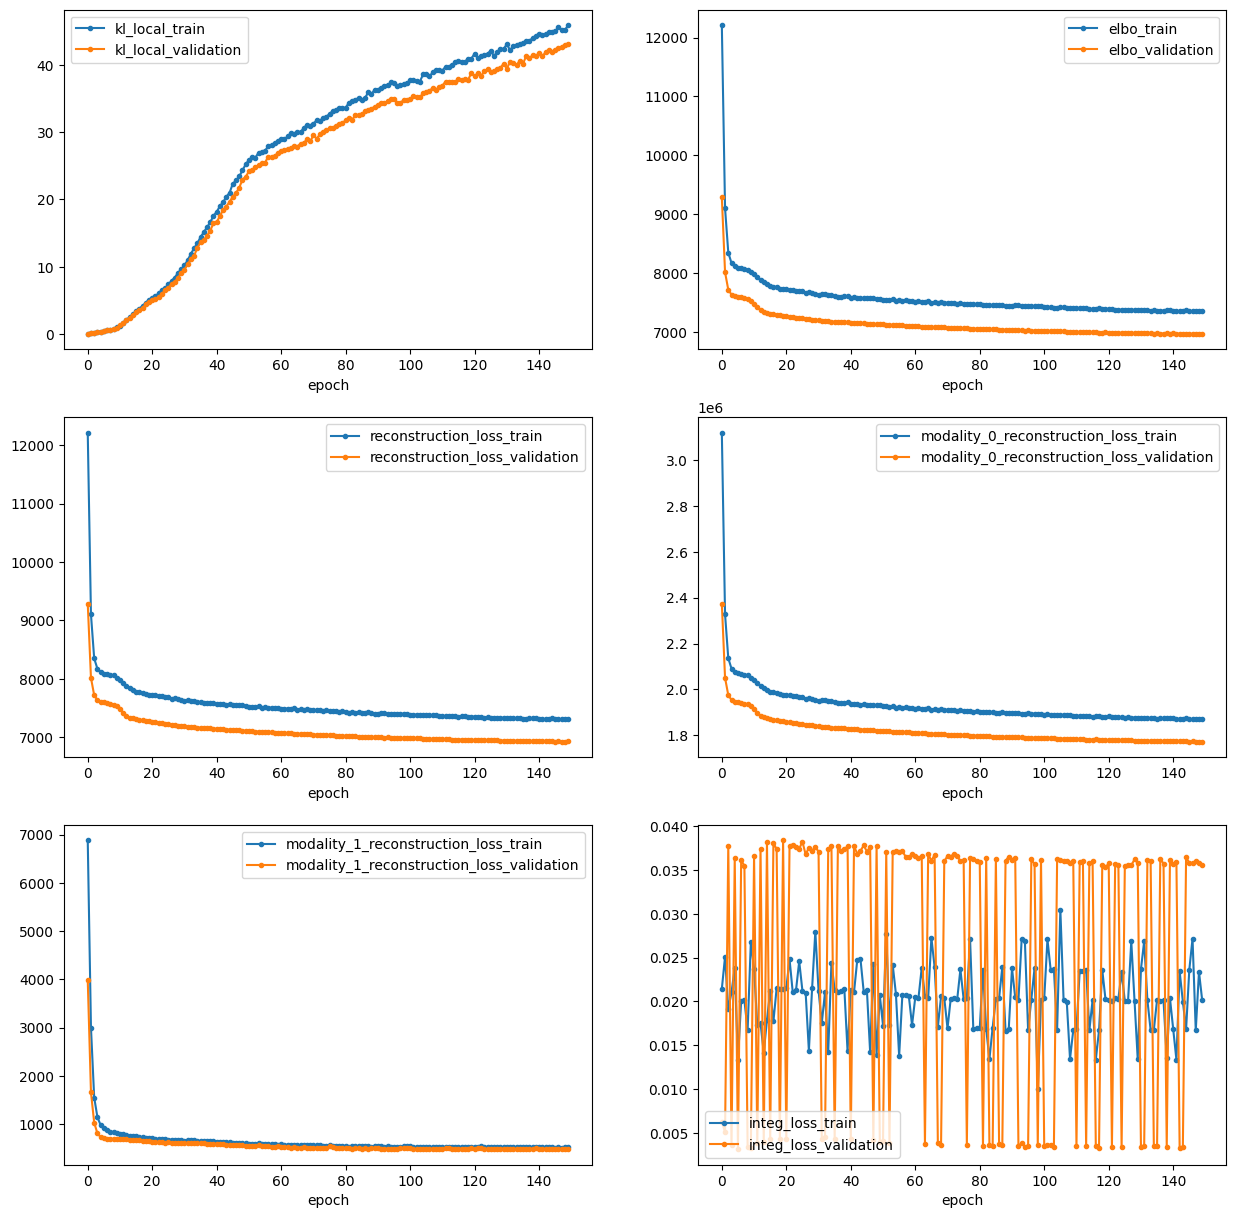

In [17]:
vae.plot_losses()

In [18]:
vae.get_model_output(batch_size=256,)
adata

AnnData object with n_obs × n_vars = 5618 × 2500
    obs: 'in_tissue', 'array_row', 'array_col', 'mt_frac', 'total_counts', 'n_counts', 'clusters', 'technology', 'random_split', 'half_split', 'og_index', 'slide', 'gex_concat_clusters', 'split', 'group', 'msi_concat_clusters', 'size_factors', '_scvi_batch'
    var: 'modality'
    uns: 'modality_lengths', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: '_scvi_extra_categorical_covs', 'X_multiMIL'
    layers: 'counts'

In [19]:
sc.pp.neighbors(adata, use_rep="X_multiMIL")
sc.tl.umap(adata)

In [20]:
adata.obs['rna_clusters'] = adata_rna.obs['clusters']
adata.obs['msi_clusters'] = adata_msi.obs['clusters']

In [47]:
sc.tl.leiden(adata, resolution=0.5)

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/scanpy/tools/_leiden.py:197: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_added] = pd.Categorical(


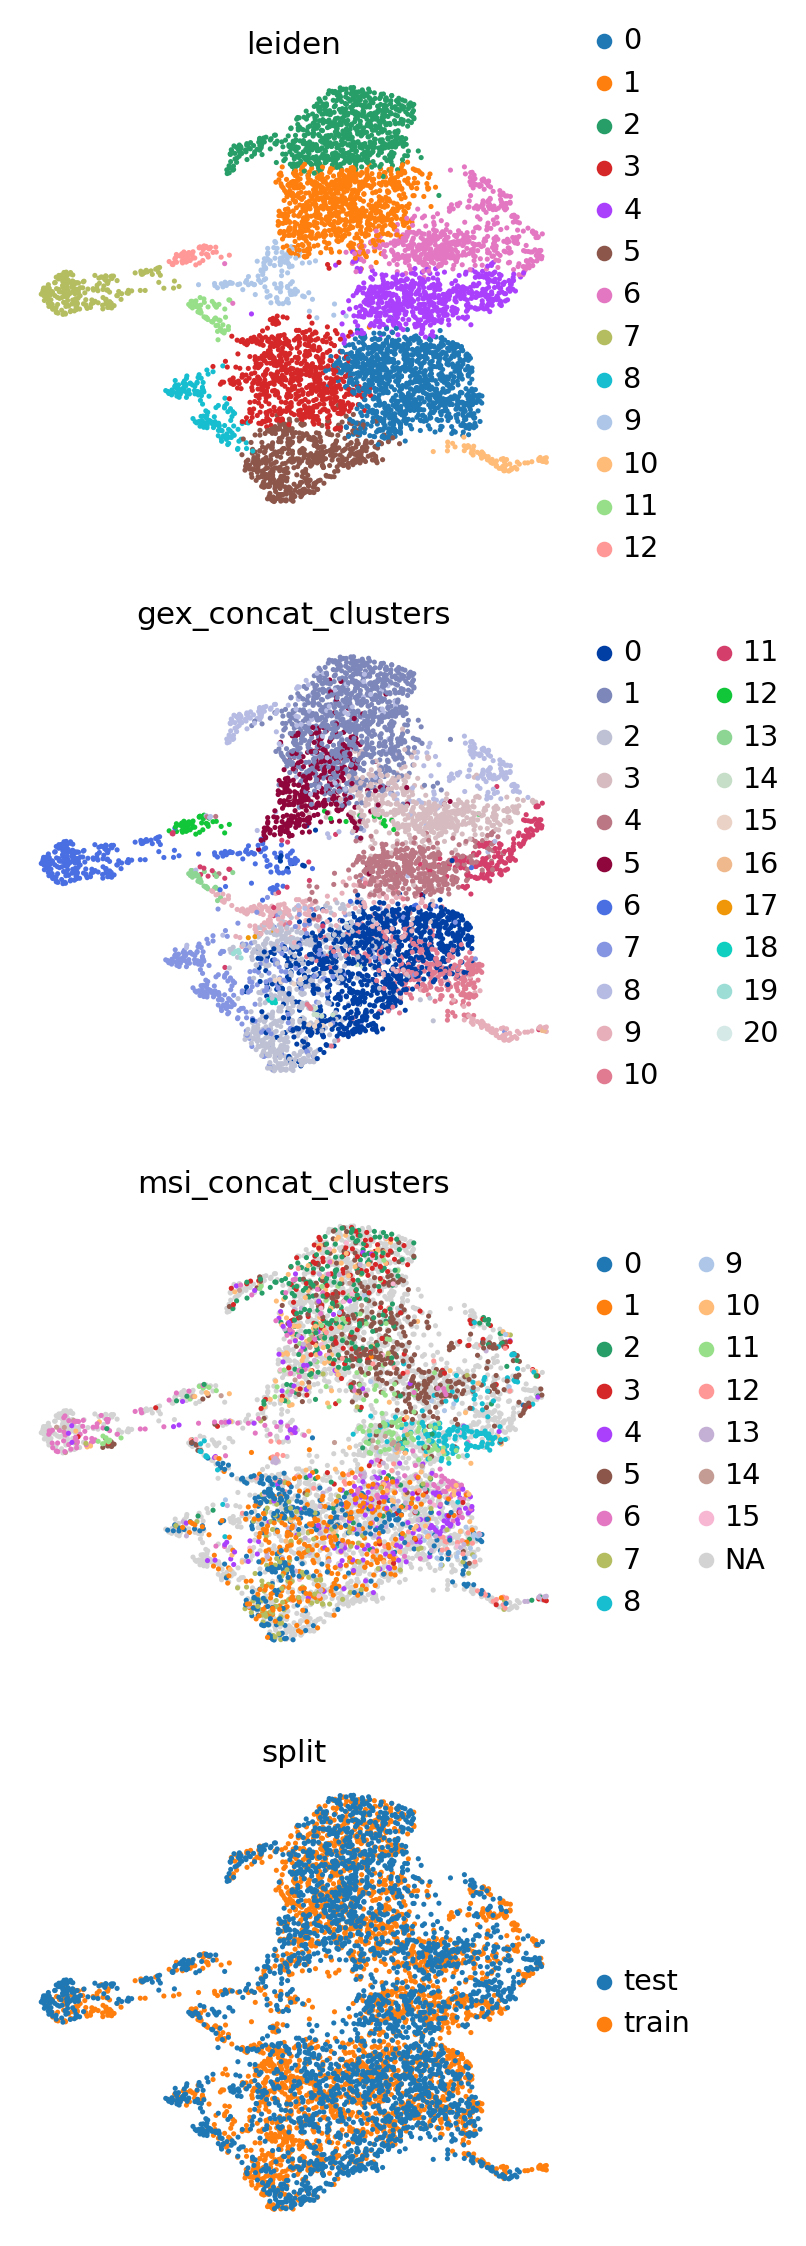

In [48]:
sc.pl.umap(adata, color=['leiden', 'gex_concat_clusters', 'msi_concat_clusters', 'split'], frameon=False, ncols=1, save='_train_in_test_umap.svg')


In [134]:
vae.save('model/')

In [133]:
adata.write('msi_query-in-train.h5ad')

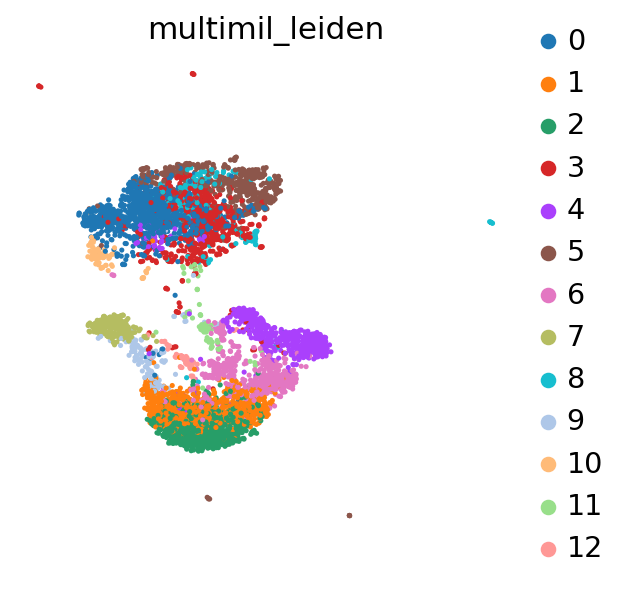

In [49]:
adata_rna.obs['multimil_leiden'] = adata.obs['leiden']
sc.pl.umap(adata_rna, color='multimil_leiden', frameon=False, ncols=1, save='_train_in_test_umap_mtm_leiden_on_rna.svg')

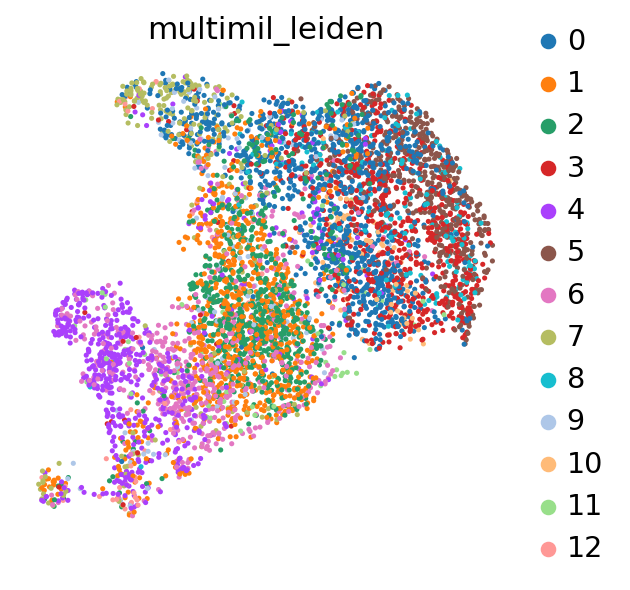

In [50]:
adata_msi.obs['multimil_leiden'] = adata.obs['leiden']
sc.pl.umap(adata_msi, color='multimil_leiden', frameon=False, ncols=1, save='_train_in_test_umap_mtm_leiden_on_msi.svg')

In [25]:
vae.impute()

In [32]:
# sc.pl.spatial(adata_rna[adata_rna.obs['slide'] == 'V11L12-109_A1'], img_key = "hires", color='multimil_leiden', spot_size=1)

# correlation stuff

In [33]:
split_key = 'split'

In [34]:
import scipy
metrics = {'train': [], 'test': []}

In [35]:
for split, adata_tmp in zip(['train', 'test'], [adata_msi_train, adata_msi_test]):
    metrics[split] = {
        'mse': sklearn.metrics.mean_squared_error(adata_tmp.X, adata[adata.obs[split_key] == split].obsm['imputed_modality_1']),
        'r2_score': sklearn.metrics.r2_score(adata_tmp.X, adata[adata.obs[split_key] == split].obsm['imputed_modality_1']),
        'pearson': scipy.stats.pearsonr(adata_tmp.X.ravel(), adata[adata.obs[split_key] == split].obsm['imputed_modality_1'].ravel())[0],
        'spearman': scipy.stats.spearmanr(adata_tmp.X.ravel(), adata[adata.obs[split_key] == split].obsm['imputed_modality_1'].ravel())[0],
    }

In [36]:
r2 = sklearn.metrics.r2_score(adata_msi_test.X, adata[adata.obs[split_key] == split].obsm['imputed_modality_1'],
                             multioutput='raw_values')

In [95]:
pearson = scipy.stats.pearsonr(adata_msi_test.X.ravel(), adata[adata.obs[split_key] == split].obsm['imputed_modality_1'].ravel())[0]
spearman = scipy.stats.spearmanr(adata_msi_test.X.ravel(), adata[adata.obs[split_key] == split].obsm['imputed_modality_1'].ravel())[0]

In [37]:
adata_msi_test.var['r2'] = r2

In [ ]:
adata_msi_test.var['spearman']

In [38]:
adata_msi_test.var[adata_msi_test.var['r2'] > 0].sort_values('r2')['r2'][-5:]

248.93283             0.232939
837.66747             0.241312
364.90545999999995    0.260090
364.902325            0.275105
364.90382             0.299725
Name: r2, dtype: float64

In [39]:
import pandas as pd
metrics = pd.DataFrame(metrics)

In [40]:
metrics

train      test
mse       0.073288  0.129157
r2_score  0.223719 -0.266155
pearson   0.962138  0.929512
spearman  0.898551  0.838562

In [102]:
sklearn.metrics.r2_score(adata_msi_test.X, adata[adata.obs[split_key] == 'test'].obsm['imputed_modality_1'])

-0.26615536910430515

In [103]:
x = adata[adata.obs[split_key] == 'test'].obsm['imputed_modality_1'].flatten()

In [104]:
y = adata_msi_test.X.flatten()

In [105]:
zero_idx = y == 0

In [106]:
from matplotlib import pyplot as plt

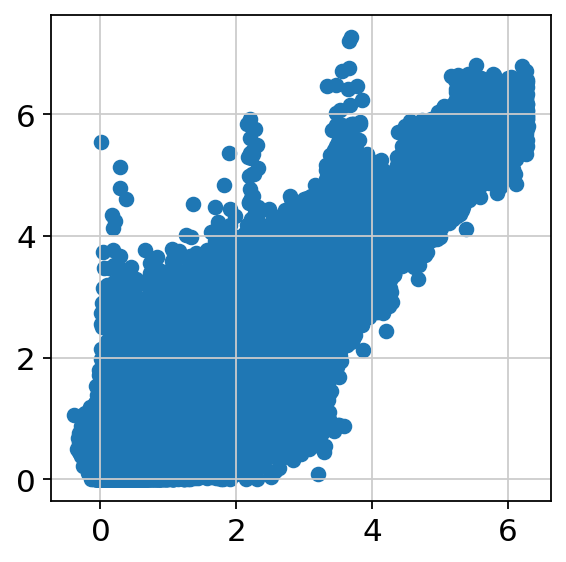

In [107]:
plt.scatter(x[~zero_idx], y[~zero_idx])

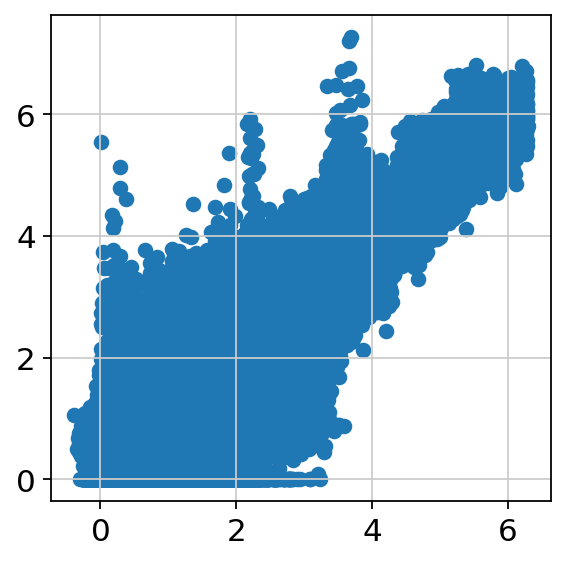

In [108]:
plt.scatter(x, y)

# spatial plots of MSI

In [51]:
adata_msi

AnnData object with n_obs × n_vars = 5618 × 500
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'msi_concat_clusters', 'split', 'multimil_leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'msi_highly_variable'
    uns: 'hvg', 'msi_concat_clusters', 'neighbors', 'pca', 'slide_colors', 'umap', 'multimil_leiden_colors'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [68]:
adata_msi_1 = adata_msi[adata_msi.obs['slide'] == 'V11L12-038_A1'].copy()
adata_msi_2 = adata_msi[adata_msi.obs['slide'] == 'V11L12-038_B1'].copy()

In [69]:
adata = adata[adata_msi.obs_names]
adata_1 = adata[adata.obs['slide'] == 'V11L12-038_A1'].copy()

In [70]:
adata_msi_1.obs['leiden'] = adata_1.obs['leiden']

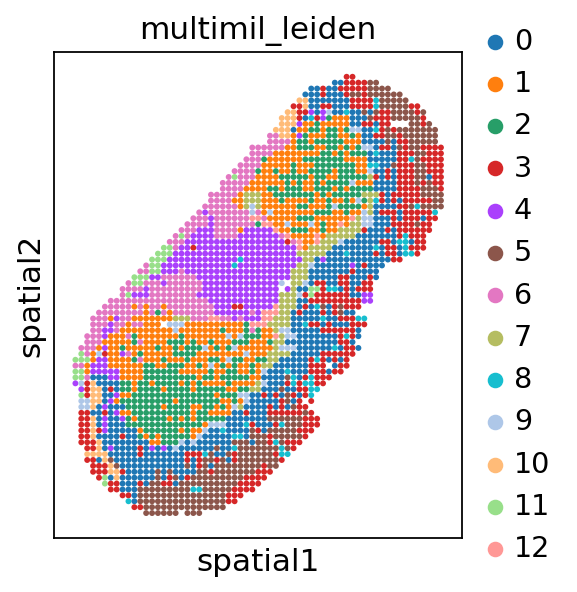

In [71]:
sc.pl.spatial(adata_msi_1, img_key = "hires", color="multimil_leiden", spot_size=1, save='_mtm_leiden_on_slide1_msi.svg')

In [72]:
adata_2 = adata[adata.obs['slide'] == 'V11L12-038_B1'].copy()

In [73]:
adata_msi_2.obs['leiden'] = adata_2.obs['leiden']

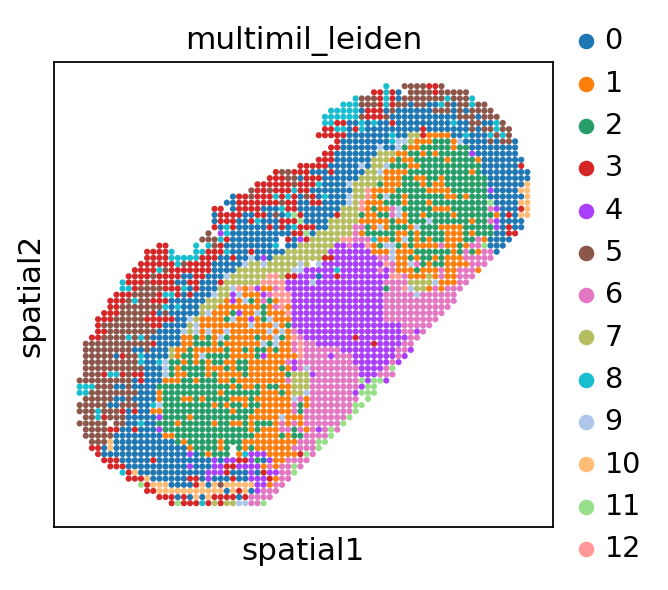

In [74]:
sc.pl.spatial(adata_msi_2, img_key = "hires", color="multimil_leiden", spot_size=1, save='_mtm_leiden_on_slide2_msi.svg')

In [129]:
def plot_feature(adata_msi_2, adata_2, feature):
    sc.pl.spatial(adata_msi_2, img_key = "hires", color=feature, spot_size=1, save=f'_msi_{feature}_true.svg')
    idx = np.where(adata_msi_2.var_names == feature)[0][0]
    tmp = adata_2[adata_msi_2.obs_names].copy()
    adata_msi_2.obs['predicted_msi_values'] = tmp.obsm['imputed_modality_1'][:, idx]
    sc.pl.spatial(adata_msi_2, img_key = "hires", color='predicted_msi_values', spot_size=1, save=f'_msi_{feature}_predicted.svg')

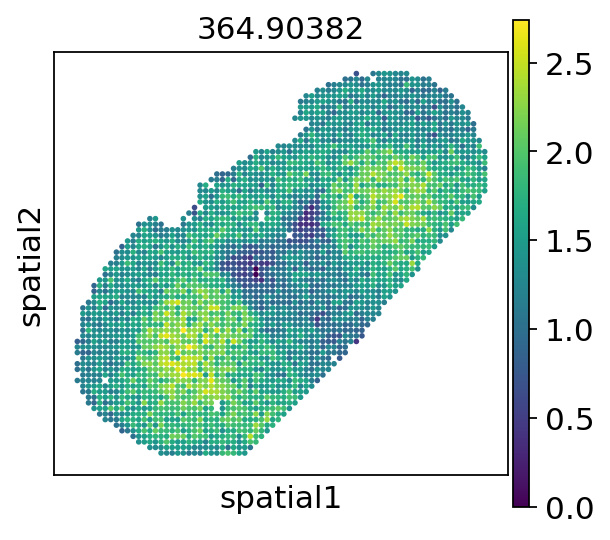

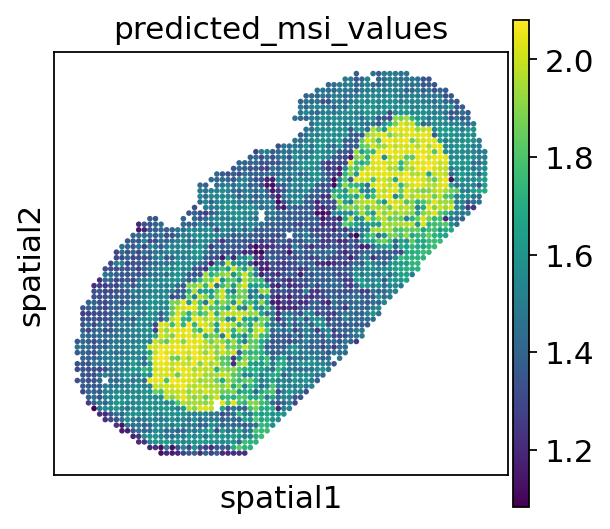

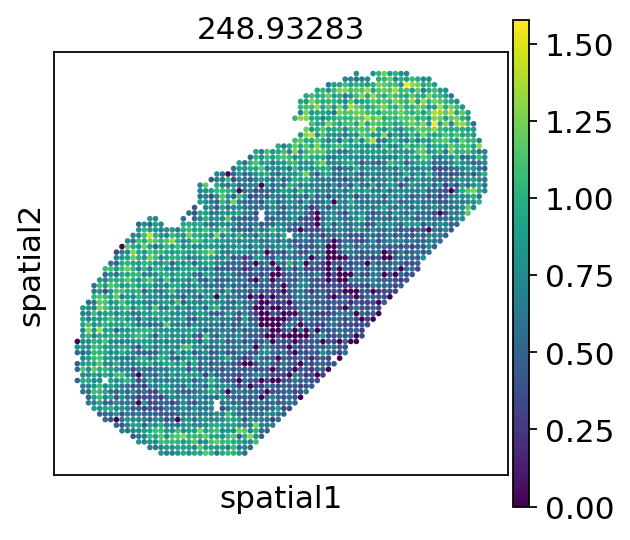

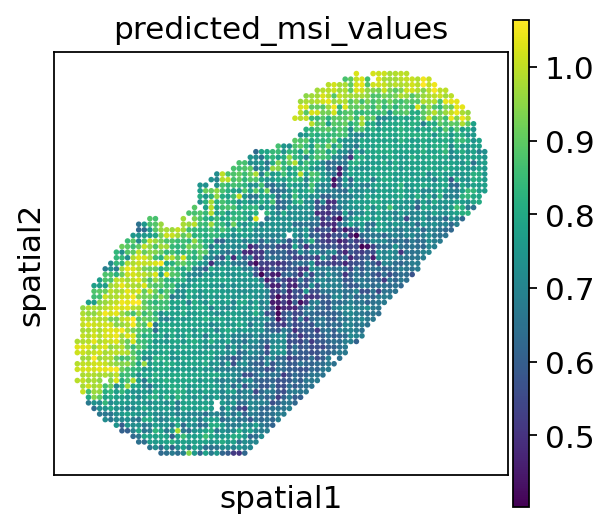

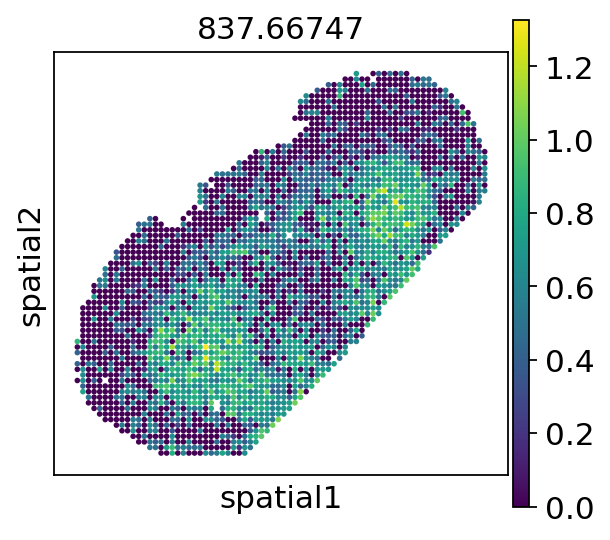

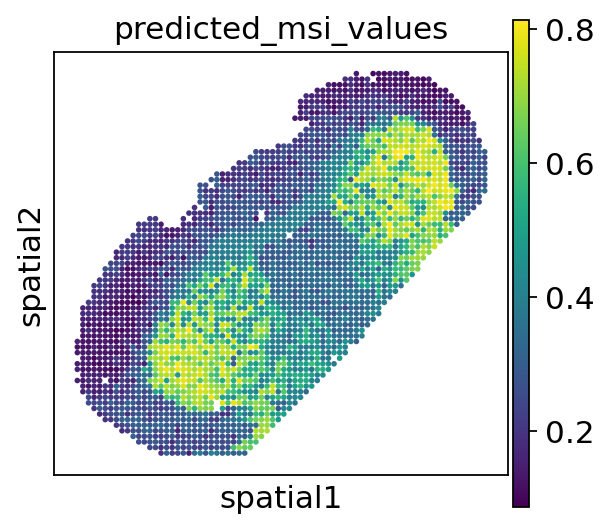

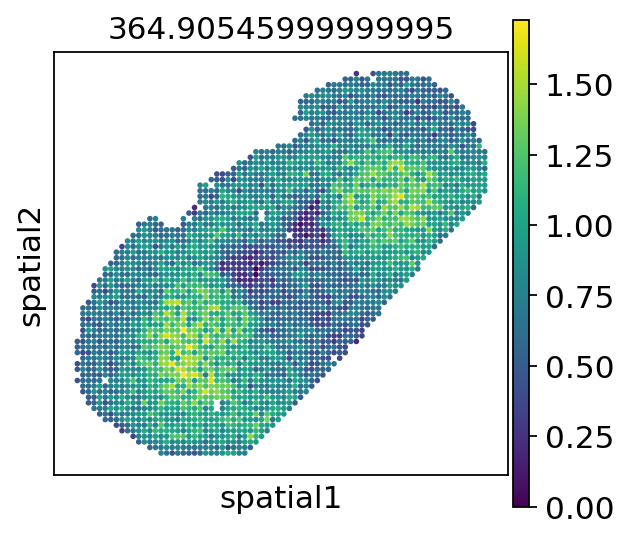

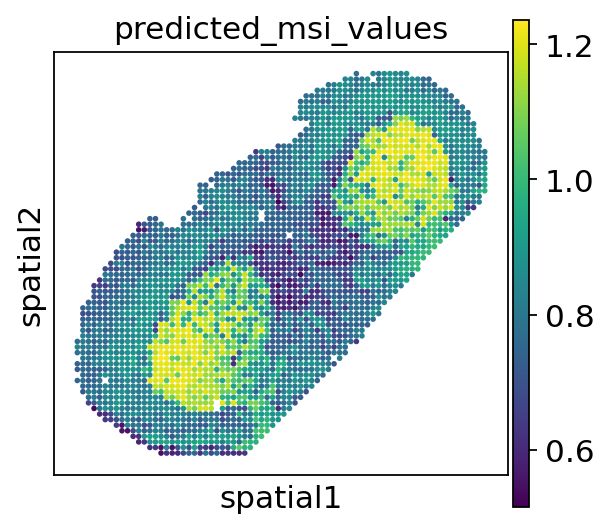

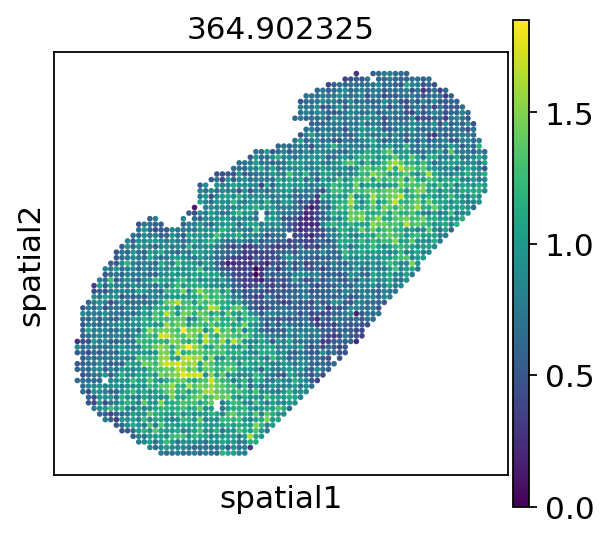

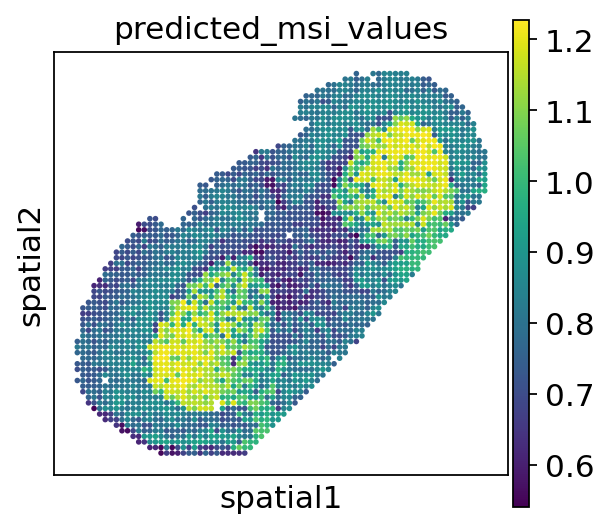

In [130]:
for feature in ['364.90382', '248.93283', '837.66747', '364.90545999999995', '364.902325']:
    plot_feature(adata_msi_2, adata_2, feature)